# HW5 Programming: On-Policy Control (Exploring Exploration)

**Paired Submission:** If you intend to work on this assignment with a partner, please form your pair _before_ you begin and work collaboratively on every written question and every component of the programming assignment. Make sure both partners are listed as group members on the last submissions to Gradescope.

**Your assignment is to:**
  * modify this notebook as specified to explore the behavior of MC and TD control algorithms.

_This assignment will be a little bit different!_ There's some relatively light coding to do, but mostly you'll be running experiments and reflecting on the results by answering short written questions.

I've marked the code cells that you should *not* change with comments. Sections where you have something to do are marked "TODO."

**You should start by duplicating this notebook:**
  - To save to your Google Drive, choose _File/Save a Copy in Drive…_ (from there you can open the file in Colab)
  - To save to your local machine, choose _File/Download/Download .ipnb_ (from there you can open the file in your favorite editor for notebooks)

When you submit, you will download the _.ipnb_ file and then upload it to Gradescope (details below).

# Imports

No need to edit these.

In [54]:
# Do not change the contents of this cell!

import math
import numpy as np
import random
from collections import namedtuple

from tqdm.notebook import trange, tqdm  # To get nice progress bars

%config InlineBackend.figure_formats = ['jpeg']
%matplotlib inline
import matplotlib.pyplot as plt         # For plotting
import seaborn as sns

plt.rcParams['figure.dpi'] = 50

# MDP and Policy Classes

Here we will define our MDP and Policy classes, which are the same as in past assignments.

Feel free to breeze on through here.

In [55]:
# Do not change the contents of this cell!

RandomVar = namedtuple("RandomVar", "values,probs")

class MDP:
  """Represents an MDP (environment).  Has two instance variables: states and
  actions which are arrays of all possible states and actions."""
  def __init__(self, states, actions):
    self.states = states
    self.actions = actions

  def resultsFor(self, s, a):
    """Given a state and action, returns a dictionary keyed by (state, reward)
    pairs whose value is the probability of that pair.

    This is similar to the p(s', r | s, a) function."""
    raise NotImplementedError

  def takeAction(self, s, a):
    """Given a state and action, returns a (next state, reward) pair, randomly
    selected according to the probabilities given by resultsFor"""
    randomNum = random.random()
    totalProb = 0
    results = self.resultsFor(s, a)
    for sprime, rwd in results:
      totalProb += results[(sprime, rwd)]
      if totalProb > randomNum:
        return (sprime, rwd)
    # Shouldn't get here!
    print("Something's wrong: transition probabilities don't add to 1!")
    return None

  def getInitialState(self):
    """Randomly selects and returns an initial state."""
    raise NotImplementedError

  def formatv(self, v):
    """Returns an easy-to-read representation of the value function."""
    return str(v)

  def formatq(self, q):
    """Returns an easy-to-read representation of the value function."""
    return str(q)

  def formatpi(self, pi):
    """Returns an easy-to-read representation of the policy."""
    return str(pi)

In [56]:
# Please do not change the contents of this cell!

class Policy:
  def __init__(self, mdp):
    self.mdp = mdp

  def actionsFor(self, state):
    """ Returns a dictionary keyed by actions, whose associated value
    is the probability of choosing that action.

    This is similar to the pi(a | s) function."""
    raise NotImplementedError

  def chooseAction(self, state):
    """ Returns an action, randomly selected using the distribution given by
    actionsFor"""
    randomNum = random.random()
    totalProb = 0
    actions = self.actionsFor(state)
    for a in actions:
      totalProb += actions[a]
      if totalProb > randomNum:
        return a
    # Shouldn't get here!
    print("Something's wrong: transition probabilities don't add to 1!")
    return None

  def __str__(self):
    """Returns the desired action for each state."""
    return str({s: self.actionsFor(s) for s in self.mdp.states})

# SimpleMDP Class

This is the same `SimpleMDP` from the previous assignment.

It is a 2-state, 2-action MDP with a persistent 10% chance of termination at every step.

In [57]:
# Do not change the contents of this cell!

class SimpleMDP(MDP):
  def __init__(self):
    super().__init__(["S1", "S2"], ["A1", "A2"])
    self.p = {
        ("S1", "A1"): {
            ("S1", 5): 0.225,
            (None, 5): 0.025,
            ("S2", 0): 0.675,
            (None, 0): 0.075
        },
        ("S1", "A2"): {
            ("S2", 0): 0.9,
            (None, 0): 0.1
        },
        ("S2", "A1"): {
            ("S2", 0): 0.9,
            (None, 0): 0.1
        },
        ("S2", "A2"): {
            ("S1", 3): 0.09,
            (None, 3): 0.01,
            ("S2", 0): 0.81,
            (None, 0): 0.09
        },
    }

  def resultsFor(self, s, a):
    """Given a state and action, returns a dictionary keyed by (state, reward)
    pairs whose value is the probability of that pair.

    This is similar to the p(s', r | s, a) function."""
    key = (s, a)
    return self.p[key]

  def getInitialState(self):
    """Randomly selects and returns an initial state."""
    if random.random() < 0.5:
      return "S1"
    else:
      return "S2"

  def __str__(self):
    return str(self.p)

# TODO: EpsilonGreedyPolicy

You'll now implement a policy that takes an _action value function_ and a parameter $\epsilon$, and chooses actions $\epsilon$-greedily.

Specifically that means:

* The _greedy_ action shoud have probability $1 - \epsilon + \frac{\epsilon}{|A|}$.
    * In the case of a tie, consider the tied action that appears _earliest_ in `self.mdp.actions` to be the greedy action.
* All other actions should have probability $\frac{\epsilon}{|A|}$.

We will let this policy use a _reference_ to the value function that is passed in so that it will continue to behave $\epsilon$-greedily as the value function changes.

In [58]:
# TODO: Implement actionsFor

class EpsilonGreedyPolicy(Policy):
  def __init__(self, mdp, q, epsilon):
    super().__init__(mdp)
    self.q = q # We do NOT make a copy of q, so behavior will change as q changes
    self.epsilon = epsilon

  def actionsFor(self, state):
    # TODO: implement this function!
    X = random.random()
    N = len(self.mdp.actions)
    # # We select the greedy policy with a 1 - \epsilon + \epsilon/|A| probability
    # if X < (1 - self.epsilon + (self.epsilon/N)):
    #   # Return the greedy action based on self.q
    #   # print("The max action: " + max(self.q, key = self.q.get)[1])
    #   return max(self.q, key = self.q.get)[1]
    # else:
    #   # We choose the exploratory action
    #   # print("The exploratory action: "+ random.choice(self.mdp.actions))
    #   return random.choice(self.mdp.actions)
    
    a= {}
    # getting the actions for only the state we are in
    state_actions = [(s, a) for (s, a) in self.q.keys() if s == state]
    ga = max(state_actions, key=lambda sa: self.q[sa])[1]
    for action in self.mdp.actions:
      a[action] = self.epsilon / N
      if action == ga:
        a[action] += (1 - self.epsilon)
    return a

Let's quickly test your `EpsilonGreedyPolicy` class.

The following snippet creates a q-function to pass to the policy, first making the action `A1` the greedy action in both states, then changing the q-function so that `A2` is greedy in state `S2`.

The policy uses $\epsilon = 0.1$.

Check that your policy assigns the correct probabilities to the actions in both states!

In [59]:
# Do not change the contents of this cell!

testMDP = SimpleMDP()
testQ = {(s, a) : 1 if a == "A1" else 0 for s in testMDP.states for a in testMDP.actions}
testPi = EpsilonGreedyPolicy(testMDP, testQ, 0.1)
print("A1 is the greedy action in both states:")
print(testMDP.formatpi(testPi))

testQ[("S2", "A2")] = 2
print("\nNow A2 is the greedy action in S2:")
print(testMDP.formatpi(testPi))

A1 is the greedy action in both states:
{'S1': {'A1': 0.9500000000000001, 'A2': 0.05}, 'S2': {'A1': 0.9500000000000001, 'A2': 0.05}}

Now A2 is the greedy action in S2:
{'S1': {'A1': 0.9500000000000001, 'A2': 0.05}, 'S2': {'A1': 0.05, 'A2': 0.9500000000000001}}


# TODO: Monte Carlo Control

Now you'll implement an algorithm that uses first-visit Monte Carlo value estimates to make decisions and improve behavior over time!

The implementation will support both exploring starts and epsilon-greedy action selection. It must use an incremental update to maintain the average returns.

In [60]:
# TODO: Fill in missing code!

Episode = namedtuple("Episode", "states, actions, stateActions, rewards")

def generateEpisode(mdp, pi, initS, initA=None):
    """Take an MDP mdp, Policy pi, and state initS and generate an episode by
    following policy pi in mdp, starting with initS.

    The optional parameter initA specifies the initial action (default None,
    in which case the initial action is selected by pi).

    Returns an Episode containing the states, actions, and rewards generated"""
    curS = initS
    if initA != None:
      a = initA
    else:
      a = pi.chooseAction(curS)

    ep = Episode([curS], [a], [(curS, a)], [None]) # Structure to store episode data
    while curS != None:
      curS, rwd = mdp.takeAction(curS, a) # Get the outcome
      ep.rewards.append(rwd)              # Record the reward obtained
      if curS != None:
        ep.states.append(curS)            # Record the next state
        a = pi.chooseAction(curS)         # Choose the next action
        ep.actions.append(a)              # Record the next action
        ep.stateActions.append((curS, a)) # And the state-action pair
    return ep

def onPolicyControlMC(mdp, numEpisodes=10000, gamma=1, epsilon=0, exploringStarts=False, progressBar=True):
  """Take an MDP mdp and return
     - The agent's policy after training
     - The agent's value function after training
     - A list of total rewards for each episode during training

     Optional parameters:
     - numEpisodes (default 10000): number of episodes to perform
     - gamma (default 1): the discount rate
     - epsilon (default 0): the exploration rate
     - exploringStarts (default False): if True, choose initial state and action uniformly randomly
     - progressBar (default True): if True, displays a progress bar counting training episodes"""
  q = {(s, a): 0 for s in mdp.states for a in mdp.actions}
  counts = {(s, a): 0 for s in mdp.states for a in mdp.actions}
  epScores = []

  pi = EpsilonGreedyPolicy(mdp, q, epsilon)  # This policy will change as q changes

  for i in tqdm(range(numEpisodes), desc="MC Eps", disable=not progressBar):
    # Choose initial state and action
    if exploringStarts:
      # TODO: set initS and initA to choices uniformly randomly selected
      #       from mdp.states and mdp.actions, respectively
      initS = random.choice(mdp.states) 
      initA = random.choice(mdp.actions)
    else:
      initS = mdp.getInitialState()
      initA = None

    # Now generate an episode
    ep = generateEpisode(mdp, pi, initS, initA)
    epScores.append(sum(ep.rewards[1:]))

    # Now ep contains all of the episode information e.g.:
    # ep.stateActions[0] is (S_0, A_0)
    # Note that ep.stateActions does not contain the very last state-action pair
    # So ep.stateActionss[-1] is (S_T-1, A_T-1)
    # but ep.rewards[-1] is R_T

    # TODO: Update action values
    # (Use the incremental update to the average)
    G = 0
    # loop through each time step backwards
    for i in range(len(ep.states))[::-1]:
      G = ep.rewards[i+1] + gamma * G   # update G value
      curStateAction = ep.stateActions[i] # get current state action

      if curStateAction not in ep.stateActions[:i]:
        counts[curStateAction] = counts.get(curStateAction, 0) + 1  # increment count
        q[curStateAction] = q[curStateAction] + (G - q[curStateAction])/counts[curStateAction]


  return pi, q, epScores

Now we can test your Monte Carlo control agent in the `SimpleMDP`.

We'll test it with exploring starts and fully greedy behavior as well as with no exploring starts and $\epsilon$-greedy behavior).

In [61]:
# Do not change the contents of this cell!

simple = SimpleMDP()

simplePiES, simpleQES, simpleScoresES = onPolicyControlMC(simple, numEpisodes=100000, exploringStarts=True, epsilon=0)
print("MC Exploring Starts:")
print("Policy:", simple.formatpi(simplePiES))
print("Q:", simple.formatq(simpleQES))

simplePiEpsilon, simpleQEpsilon, simpleScoresEpsilon = onPolicyControlMC(simple, numEpisodes=100000, exploringStarts=False, epsilon=0.1)
print("MC Epsilon-greedy:")
print("Policy:", simple.formatpi(simplePiEpsilon))
print("Q:", simple.formatq(simpleQEpsilon))

MC Eps:   0%|          | 0/100000 [00:00<?, ?it/s]

MC Exploring Starts:
Policy: {'S1': {'A1': 1.0, 'A2': 0.0}, 'S2': {'A1': 0.0, 'A2': 1.0}}
Q: {('S1', 'A1'): 5.096982944082048, ('S1', 'A2'): 3.598115166520243, ('S2', 'A1'): 3.4901228619609608, ('S2', 'A2'): 3.990738622124877}


MC Eps:   0%|          | 0/100000 [00:00<?, ?it/s]

MC Epsilon-greedy:
Policy: {'S1': {'A1': 0.9500000000000001, 'A2': 0.05}, 'S2': {'A1': 0.05, 'A2': 0.9500000000000001}}
Q: {('S1', 'A1'): 4.854571106094788, ('S1', 'A2'): 3.4574839055793967, ('S2', 'A1'): 3.3808813289565314, ('S2', 'A2'): 3.757805870917165}


Below are the results I got. Yours will differ, but usually shouldn't be too far off.

```
MC Exploring Starts:
Policy: {'S1': {'A1': 1.0, 'A2': 0.0}, 'S2': {'A1': 0.0, 'A2': 1.0}}
Q: {('S1', 'A1'): 5.076259091768887, ('S1', 'A2'): 3.6017773172869854, ('S2', 'A1'): 3.5978697749196153, ('S2', 'A2'): 3.983475938743277}
```
```
MC Epsilon-greedy:
Policy: {'S1': {'A1': 0.9500000000000001, 'A2': 0.05}, 'S2': {'A1': 0.05, 'A2': 0.9500000000000001}}
Q: {('S1', 'A1'): 4.842417448312025, ('S1', 'A2'): 3.3426592059685536, ('S2', 'A1'): 3.38060323279454, ('S2', 'A2'): 3.7368245962333}
```


# The Blackjack Class

You'll be using your Monte Carlo algorithm to solve the Blackjack problem from Example 5.1 (p. 93).

Below you'll find a class that represents the Blackjack problem and some code for visualizing policies and value functions in Blackjack.

You don't need to edit these at all. To save you some scrolling, I've hidden the cell, but feel free to take a peek if you want.

In [62]:
# Do not change the contents of this cell!

class Blackjack(MDP):
  def __init__(self):
    super().__init__([(dlr, player, False)
                        for dlr in range(2, 12)
                        for player in range(4, 22)] +
                     [(dlr, player, True)
                        for dlr in range(2, 12)
                        for player in range(11, 22)],
                     ["H", "S"] )

  def dealCard(self):
    # 10 appears four times for the ten, J, Q, and K
    return random.choice([2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11])

  def total(self, cards, debug=False):
    tot = 0
    numAces = 0
    for card in cards:
      if card == 11:
        numAces += 1
      tot += card
    while tot > 21 and numAces > 0:
      numAces -= 1
      tot -= 10
    if debug:
      print(f'Total({cards}) = {tot}')
    return tot

  def getInitialState(self):
    dlrCard = self.dealCard()
    playerCards = [self.dealCard(), self.dealCard()]
    playerTot = self.total(playerCards)
    usableAce = playerCards[0] == 11 or playerCards[1] == 11
    return (dlrCard, playerTot, usableAce)

  def takeAction(self, s, a, debug=False):
    """Given a state and action, returns a  state, reward
    pair.

    This is similar to the p(s', r | s, a) function."""
    dlrUpCard, playerTot, playerUsableAce = s
    if debug:
      print(f'takeAction({s}, {a})')
    if a == "H":
      playerUsableAces = 1 if playerUsableAce else 0
      card = self.dealCard()
      if card == 11:
        playerUsableAces += 1
      if playerTot + card > 21 and playerUsableAces > 0:
        card -= 10
        playerUsableAces -= 1
      if debug:
        print(f'Hit: got ', card)
      newTot = playerTot + card
      if newTot <= 21:
        return ((dlrUpCard, newTot, playerUsableAces > 0), 0)
      else:
        return (None, -1)
    else:
      dlrCards = [dlrUpCard]
      while self.total(dlrCards) < 17:
        dlrCards.append(self.dealCard())
      dlrTotal = self.total(dlrCards)
      if dlrTotal > 21 or dlrTotal < playerTot:
        return (None, 1)
      elif dlrTotal == playerTot:
        return (None, 0)
      else:
        return (None, -1)

  def formatv(self, v):
    lines = []
    for usableAce in [True, False]:
      lines.append(f'usableAce: {usableAce}')
      lines.append("      A    2    3    4    5    6    7    8    9    T")
      for player in reversed(range(12, 21)):
        lines.append(f'{player}: ' + (" ".join([f'{v[(dlr, player, usableAce)]:4.1f}' for dlr in [11, 2, 3, 4, 5, 6, 7, 8, 9, 10]])))
    return "\n".join(lines)

  def formatpi(self, pi):
    lines = []
    for usableAce in [True, False]:
      lines.append(f'usableAce: {usableAce}')
      lines.append("      A    2    3    4    5    6    7    8    9    T")
      for player in reversed(range(12, 21)):
        lines.append(f'{player}: ' + (" ".join([f'{pi.actionsFor((dlr, player, usableAce))["H"]:4.2f}' for dlr in [11, 2, 3, 4, 5, 6, 7, 8, 9, 10]])))
    return "\n".join(lines)

m = Blackjack()

This is some code for visualizing the policies and value functions you calculate. You don't need to edit it either.

In [63]:
# Do not change the contents of this cell!

def actionHeatMap(pi, usableAce):
  heatmap = np.zeros((18, 10))
  for dlr in range(1, 11):
    actualDlr = dlr if dlr > 1 else 11
    lowTotal = 12 if usableAce else 4
    for plyr in range(lowTotal, 22):
      heatmap[21-plyr, dlr-1] = pi.actionsFor((actualDlr, plyr, usableAce))["H"]
    for plyr in range(4, lowTotal):
      heatmap[21-plyr, dlr-1] = 0.5
  return heatmap

def valueHeatMap(v, usableAce):
  heatmap = np.zeros((18, 10))

  for dlr in range(1, 11):
    actualDlr = dlr if dlr > 1 else 11
    lowTotal = 12 if usableAce else 4
    for plyr in range(lowTotal, 22):
      state = (actualDlr, plyr, usableAce)
      heatmap[21-plyr, dlr-1] = v[state]
    for plyr in range(4, lowTotal):
      heatmap[21-plyr, dlr-1] = 0
  return heatmap

def plotHeatMaps(pis, vs, names):
  numRows = 2
  numCols = len(pis)*2
  fig, ax = plt.subplots(numRows, numCols, figsize=(5*numCols, 5*numRows))

  dealerCards = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
  playerTotals = [str(i) for i in range(21, 3, -1)]

  policyColormap = "RdGy_r"
  piHeatMaps = [actionHeatMap(pi, ace) for pi in pis for ace in [True, False]]
  piTitles = [name+": Prob. of Hit"+a+" usable Ace" for name in names for a in [" with", " without"]]
  aceMask = np.zeros((18, 10))
  aceMask[9:18, :] = True
  masks = [aceMask, None, aceMask, None]
  for c in range(numCols):
    sns.heatmap(piHeatMaps[c], ax=ax[0,c],
                cmap=policyColormap, vmin=0, vmax=1, cbar=False,
                annot=True, fmt="4.2f",
                mask=masks[c])
    ax[0,c].set_title(piTitles[c])
    ax[0,c].set_xticks([])
    ax[0,c].set_yticks([])
  ax[0,0].set_yticks([y+0.5 for y in range(18)])
  ax[0,0].set_yticklabels(playerTotals)
  ax[0,0].set_ylabel("Player Sum")

  valueColormap = "PuOr_r"
  vHeatMaps = [valueHeatMap(v, ace) for v in vs for ace in [True, False]]
  vTitles = [name+": Values"+a+" usable Ace" for name in names for a in [" with", " without"]]
  for c in range(numCols):
    sns.heatmap(vHeatMaps[c], ax=ax[1,c],
                cmap=valueColormap, center=0, cbar=False,
                annot=True, fmt="4.2f",
                xticklabels=dealerCards,
                mask=masks[c])
    ax[1,c].set_title(vTitles[c])
    ax[1,c].set_xlabel("Dealer Showing")
    ax[1,c].set_yticks([])
  ax[1,0].set_yticks([y+0.5 for y in range(18)])
  ax[1,0].set_yticklabels(playerTotals)
  ax[1,0].set_ylabel("Player Sum")

  for c in range(1, numCols):
    for r in range(numRows):
      ax[r,c].set_yticks([])

  plt.tight_layout()
  plt.show();

# TODO: Solving Blackjack!

Get ready to calculate an (approximately) optimal policy for Blackjack!

Run the below cell to apply Monte Carlo control to this problem in two ways:
- Exploring starts, $\epsilon = 0$
- No exploring starts, $\epsilon = 0.4$

MC Eps:   0%|          | 0/5000000 [00:00<?, ?it/s]

MC Eps:   0%|          | 0/5000000 [00:00<?, ?it/s]

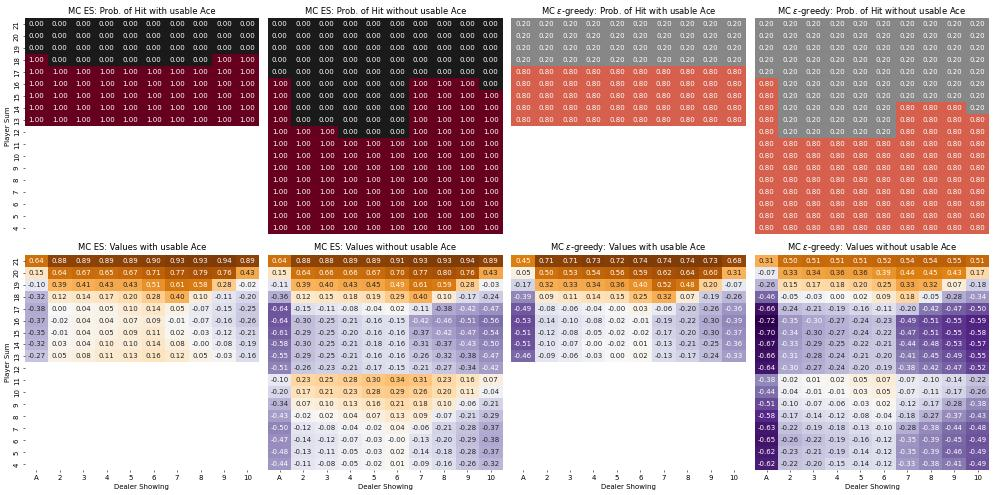

In [64]:
# TODO: update NUM_EPISODES as instructed below
NUM_EPISODES = 5000000

piES, qES, scoresES = onPolicyControlMC(m, numEpisodes=NUM_EPISODES, exploringStarts=True, epsilon=0)
vES = {state: max(qES[(state, "S")], qES[(state, "H")]) for state in m.states}

piEpsilon, qEpsilon, scoresEpsilon = onPolicyControlMC(m, numEpisodes=NUM_EPISODES, exploringStarts=False, epsilon=0.4)
vEpsilon = {state: piEpsilon.actionsFor(state)["S"]*qEpsilon[(state, "S")] + \
                   piEpsilon.actionsFor(state)["H"]*qEpsilon[(state, "H")] for state in m.states}

plotHeatMaps([piES, piEpsilon], [vES, vEpsilon], ["MC ES", r"MC $\epsilon$-greedy"])

Compare your exploring starts results to the results displayed in Figure 5.2 (p. 100). Your results will be pretty noisy in comparison.

The experiment that generated that figure started the agent with a reasonably informed policy (the one that sticks at 20 and 21). In contrast, we started our agent out from scratch. Apparently, it still needs more training!

I find that it takes about 5,000,000 episodes to get reasonably consistent results. That's a lot of Blackjack! Change `NUM_EPISODES` to 5,000,000 and re-run the experiment. Your results should be much cleaner and your exploring starts results should be very similar to Figure 5.2 (possibly with a few deviations here or there).

Even with 5,000,000 episodes, my implementation takes less than 2 minutes to generate the results. If yours is much slower, then you probably have some inefficiencies in your MC code. Efficiency is not a factor in the grading, but if it's uncomfortably slow for you, then it might be worth it to go back and make some improvements.

# TODO: Blackjack Questions

Edit this cell with a brief answers to the following questions:

**Question 1:** The two exploration strategies (exploring starts and $\epsilon$-greedy behavior) came up with noticeably different policies, even if we ignore the $\epsilon$-softness of the latter. Compare the _greedy_ policies from each method (shown by the colors in the policy plots: red for hit, gray/black for stick). Describe the main differences that you see in the two greedy policies.

**Answer:** The main difference that I notice between the exploring starts and $\epsilon$-greedy policies is that the $\epsilon$-greedy policy is more conservative than the exploring starts policy. This means that the $\epsilon$-greedy policy chooses to "stay" in situations where the exploring starts policy will chose to "hit". This especially occurs in borderline or "risky" states.

**Question 2:** Using your knowledge about the two algorithms, explain those differences.

**Answer:** The exploring starts strategy ensures that all state-action pairs are explored since it begins episodes from random states and actions. It then always picks the greedy choice. In contrast, the $\epsilon$-greedy strategy always has the chance to take a random (non-greedy) action. This means that the $\epsilon$-greedy policy will always be a mixture of greedy and random actions. This makes the $\epsilon$-greedy policy more conservative since it must account for random "risky" moves.

**Question 3:** The value functions produced by the two agents have similar shapes, but the $\epsilon$-greedy agent generally estimated lower values. Why is that?

**Answer:** The $\epsilon$-greedy agent value estimates are generally lower since there is alawys a chance of taking random, and non-greedy, actions. These non-greedy outcomes are more likely to lead to worse outcomes. The value funtion for the $\epsilon$-greedy strategy reflects this with lower values in comparison to the only greedy policy (exploring starts).

# TODO: Sarsa

We've also discussed on-policy control using the temporal difference method.

Below, complete the implementation of Sarsa.

**Important Note:** Be careful about how to handle terminal states! In our codebase, the MDP will return `None` as the state when the episode has terminated. It doesn't make sense to ask the policy for an action to take from the state `None`. Nevertheless, you need to make sure that the update on the last step of the episode is correct (remember that the value of a terminal state is always 0).

In [ ]:
# TODO: Fill in the missing code!

def sarsa(mdp, numEpisodes=10000, gamma=1, epsilon=0.1, alpha=0.1, progressBar=True, printEp=False):
  """Take an MDP mdp and return
     - The agent's policy after training
     - The agent's value function after training
     - A list of total rewards for each episode during training

     Optional parameters:
     - numEpisodes (default 10000): number of episodes to perform
     - gamma (default 1): the discount rate
     - epsilon (default 0.1): the exploration rate
     - alpha (default 0.1): the step size
     - progressBar (default True): if True, displays a progress bar counting training episodes
     - printEp (default False): if True, prints updates and policies during training"""

  q = {(s, a): 0 for s in mdp.states for a in mdp.actions}
  epScores = []

  pi = EpsilonGreedyPolicy(mdp, q, epsilon)  # This policy will change as q changes
  for i in tqdm(range(numEpisodes), desc="Sarsa Eps", disable=not progressBar):
    epScores.append(0)

    curS = mdp.getInitialState()
    curA = pi.chooseAction(curS)

    step = 0
    while curS != None:
      nextS, r = mdp.takeAction(curS, curA)

      # Bookkeeping for print statements/return values
      epScores[-1] += r
      oldVal = q[curS, curA]
      step += 1
      if printEp:
        print("Step " + str(step))
        print("Current policy:")
        print(mdp.formatpi(pi))
        print("Current state:", curS)
        valStr = "Q-values -- "
        for a in mdp.actions:
          valStr += str(a) + ": " + str(q[curS, a]) + ", "
        print(valStr[:-2])
        print("Selected action:", curA)
        print("Next state:", nextS, "Reward:", r)

      # logic to determine if nextA
      if nextS == None:
        # nextS is terminal so we know that the value of the next state action pair will be 0
        q[(curS, curA)] = q[(curS, curA)] + alpha * (r - q[(curS, curA)])
      else: 
        nextA = pi.chooseAction(nextS) # getting nextA
        # update step
        q[(curS, curA)] = q[(curS, curA)] + alpha * (r + gamma * q[(nextS, nextA)] - q[(curS, curA)])


      # If directed to, print the update
      if printEp:
        print("q("+str(curS)+","+str(curA)+"): " + str(oldVal)+" -> " + str(q[curS, curA])+"\n")

      # Finally, move time forward and loop back around
      curS = nextS
      curA = nextA

  return pi, q, epScores

Next you can test your sarsa implementation using the `SimpleMDP`.

In [67]:
simplePiSarsa, simpleQSarsa, simpleScoresSarsa = sarsa(simple, numEpisodes=100000, epsilon=0.1, alpha=0.01)
print("Sarsa:")
print("Policy:", simple.formatpi(simplePiSarsa))
print("Q:", simple.formatq(simpleQSarsa))

Sarsa Eps:   0%|          | 0/100000 [00:00<?, ?it/s]

Sarsa:
Policy: {'S1': {'A1': 0.9500000000000001, 'A2': 0.05}, 'S2': {'A1': 0.05, 'A2': 0.9500000000000001}}
Q: {('S1', 'A1'): 5.022611898717274, ('S1', 'A2'): 3.289902231005202, ('S2', 'A1'): 3.2996204877767124, ('S2', 'A2'): 3.490440296411133}


Ideally we'd get results similar to what we got with $\epsilon$-greedy Monte Carlo control. In practice, I find that the Sarsa-estimated values are noisier, most likely because of the constant step size, though it should get the optimal policy correct.

Here's what I got with Sarsa. Your results should not be too far off.

```
Sarsa:
Policy: {'S1': {'A1': 0.9500000000000001, 'A2': 0.05}, 'S2': {'A1': 0.05, 'A2': 0.9500000000000001}}
Q: {('S1', 'A1'): 4.371453873536995, ('S1', 'A2'): 3.476664806327927, ('S2', 'A1'): 2.9366140159141927, ('S2', 'A2'): 3.184413370263701}
```

For reference, here are my results using Monte Carlo again.

```
MC Epsilon-greedy:
Policy: {'S1': {'A1': 0.9500000000000001, 'A2': 0.05}, 'S2': {'A1': 0.05, 'A2': 0.9500000000000001}}
Q: {('S1', 'A1'): 4.842417448312025, ('S1', 'A2'): 3.3426592059685536, ('S2', 'A1'): 3.38060323279454, ('S2', 'A2'): 3.7368245962333}
```

# CliffWalk Class

The following `MDP` represents the Cliff Walking task discussed in Example 6.6 (p. 132). You don't need to edit it.

In [68]:
# Do not change the contents of this cell!

class CliffWalk(MDP):
  def __init__(self):
    super().__init__([(x,y) for x in range(12) for y in range(4)],
                     ["R", "D", "U", "L"])
    self.width = 12
    self.height = 4

  def resultsFor(self, s, a):
    """Given a state and action, returns a dictionary keyed by (state, reward)
    pairs whose value is the probability of that pair.

    This is similar to the p(s', r | s, a) function."""
    x, y = s
    newX = x
    newY = y

    if a == "R":
      newX = x + 1
    elif a == "D":
      newY = y - 1
    elif a == "U":
      newY = y + 1
    elif a == "L":
      newX = x - 1

    if newX < 0 or \
       newX >= self.width or \
       newY < 0 or \
       newY >= self.height:
      newX = x
      newY = y

    if newY == 0 and newX > 0:
      if newX < self.width - 1:
        return {((0, 0), -100) : 1}
      else:
        return {(None, -1): 1}
    else:
      return {((newX, newY), -1) : 1}

  def getInitialState(self):
    """Selects and returns an initial state."""
    return (0, 0)

  def formatq(self, q):
    lines = []
    for y in range(self.height-1, -1, -1):
      line = ""
      for x in range(self.width):
        acts = self.actions
        for a in acts:
          line += a + "(" + str(q[(x, y), a]) + ")"
        line += " | "
      lines.append(line)
    return "\n".join(lines)

  def formatpi(self, pi):
    lines = []
    for y in range(self.height-1, -1, -1):
      line = ""
      for x in range(self.width):
        mostLikelyAct = None
        maxProb = 0
        acts = pi.actionsFor((x, y))
        for a in acts:
          if acts[a] > maxProb:
            maxProb = acts[a]
            mostLikelyAct = a
        line += mostLikelyAct
      lines.append(line)
    return "\n".join(lines)

cliff = CliffWalk()

We can also test your Sarsa implementation in this problem:

In [69]:
# Do not change the contents of this cell!

sarsaPi, sarsaQ, sarsaScores = sarsa(cliff, numEpisodes=100000)
print("Policy (most likely action):")
print(cliff.formatpi(sarsaPi))

Sarsa Eps:   0%|          | 0/100000 [00:00<?, ?it/s]

Policy (most likely action):
RRRRRRRRRRRD
UUURRRRRRRRD
UUUUUUUUUURD
URRRRRRRRRRR


The printed output here will show the most likely action in every state (i.e. the greedy choice).

You should find that, as predicted in the figure accompanying the example, your agent has learned to take the "Safer Path" (though it may have some minor deviations).

# TODO: Experiment With Step Size

In this section you'll compare the performance of Sarsa with different values of $\alpha$ (the step size) and answer a few questions to reflect on the findings.

First, a bit of code to support plotting the results.

In [70]:
# Do not change the contents of this cell!

def plot_avg_scores(scores, names, colors):
  fig, ax = plt.subplots(1, 2, figsize=(20, 5))

  for a in range(2):
    ax[a].set_xlabel("Episodes")
    ax[a].set_ylabel("Average Score")
    xs = range(len(scores[0]))
    ax[a].axhline(-13, c="black",label="Optimal")
    for i in range(len(scores)):
      ax[a].plot(xs, scores[i], label=names[i], c=colors[i])
  ax[0].set_title("Cliff Walk")
  ax[1].set_title("Zoom and Enhance!")
  ax[0].legend(loc='lower right')
  ax[1].set_ylim(-100, 0)

  plt.show();

This cell will run 100 independent trials using Sarsa in the Cliff Walk with $\alpha$ values 0.01, 0.1, and 0.9 (all with $\epsilon = 0.1$). Then it will plot the average scores over time.

Note: my implementation takes less than 1 minute to generate the results. If yours is uncomfortably slow, consider improving the efficiency of your implementation!

alpha=0.01:   0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.1:   0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.9:   0%|          | 0/100 [00:00<?, ?it/s]

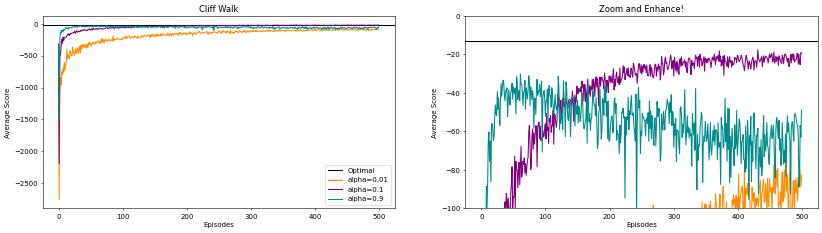

In [71]:
numTrials = 100  # <- Change this value (see below)
numEps = 500

alphas = [0.01, 0.1, 0.9]
colors=["darkorange", "purple", "darkcyan"]
scores = [[0]*numEps for a in alphas]
names = ["alpha="+str(a) for a in alphas]
for alg in range(len(alphas)):
  for trial in trange(numTrials, desc=names[alg]):
    resultPi, resultQ, resultScores = sarsa(cliff, alpha=alphas[alg], numEpisodes=numEps, progressBar=False)
    for i in range(numEps):   # For each episode, add in the score
      scores[alg][i] += resultScores[i]/numTrials

plot_avg_scores(scores, names, colors)

Your results should look roughly like mine:
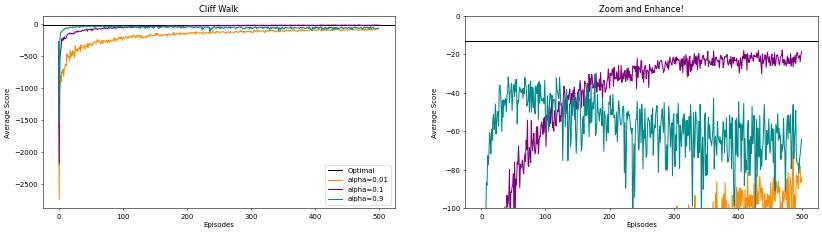

Briefly answer the following questions:

**Question 4:** The yellow curve ($\alpha = 0.01$) seems to be taking much longer than the others to learn a good policy. Why?

**Answer:** The $\alpha$ term represents the step size of the sarsa function. A smaller step size results in the state-action values being updated a slower rate. Therefore they take longer to converge to the optimal state-action value. Since the policy is dependent on the current state-action values the policy will take longer to converge to a "good" policy.

**Question 5:** The purple curve ($\alpha = 0.1$) comes close to optimal performance but seems to be leveling off before it fully reaches it. Why?

**Answer:** The purple curve comes close to optimal performance but levels off before it fully reaches it because it has an $\epsilon$ exploration rate of $0.1$. This mean that there will always be a 10% chance that a random action is taken. Since this random action can be non-greedy the policy will never be completely optimal.

**Question 6:** The cyan curve ($\alpha = 0.9$) gets off to a fast start, but eventually performance starts to (slightly) degrade. Why?

**Answer:** The cyan curve gets off to such a fast start since it updates the state action values with such a high probability. However, such a large step size can cause the value estimates to "overshoot" which leads to instability and slightly worse performance in the long run.


# TODO: Experiment with Exploration Rate

In this section you'll compare the performance of Sarsa with different values of $\alpha$ (the step size) and answer a few questions to reflect on the findings.

This cell will run 100 independent trials using Sarsa in the Cliff Walk with $\epsilon$ values 0, 0.01, and 0.1 (all with $\alpha = 0.1$). Then it will plot the average scores over time.

epsilon=0:   0%|          | 0/100 [00:00<?, ?it/s]

epsilon=0.01:   0%|          | 0/100 [00:00<?, ?it/s]

epsilon=0.1:   0%|          | 0/100 [00:00<?, ?it/s]

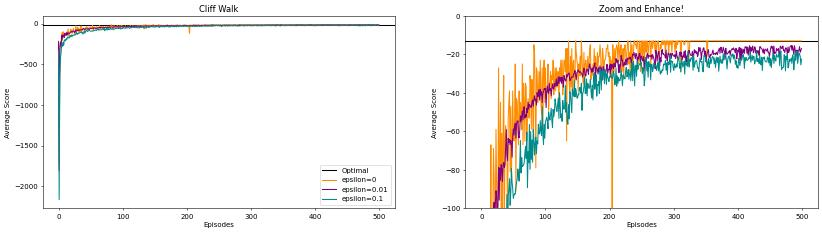

In [72]:
numTrials = 100  # <- Change this value (see below)
numEps = 500

epsilons = [0, 0.01, 0.1]
colors=["darkorange", "purple", "darkcyan"]
scores = [[0]*numEps for e in epsilons]
names = ["epsilon="+str(e) for e in epsilons]
for alg in range(len(epsilons)):
  for trial in trange(numTrials, desc=names[alg]):
    resultPi, resultQ, resultScores = sarsa(cliff, epsilon=epsilons[alg], numEpisodes=numEps, alpha=0.1, progressBar=False)
    for i in range(numEps):   # For each episode, add in the score
      scores[alg][i] += resultScores[i]/numTrials

plot_avg_scores(scores, names, colors)

Your results should look roughly like mine:
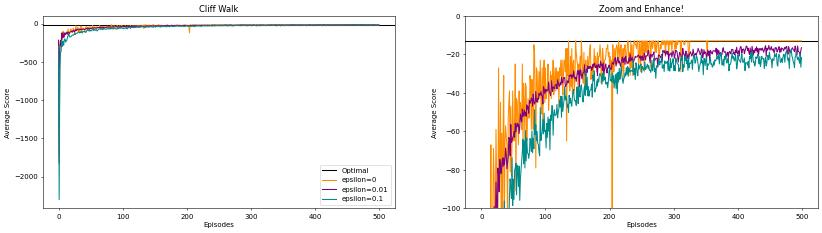

Huh. It's kind of surprising that Sarsa with $\epsilon = 0$ does so well, isn't it? By the end, it looks like it is performing optimally.

Let's check the policy it comes up with in the next cell.

In [73]:
greedyPi, greedyQ, greedyScores = sarsa(cliff, numEpisodes=100000, epsilon=0)
print("Policy (most likely action):")
print(cliff.formatpi(greedyPi))

Sarsa Eps:   0%|          | 0/100000 [00:00<?, ?it/s]

Policy (most likely action):
DURRLRDURRRD
RRRRRRRRRRRD
RRRRRRRRRRRD
URRRRRRRRRRR


You should see that it has learned to follow the "Optimal path" from the figure in the book.

It's kind of odd that the agent could learn the optimal policy without taking any exploratory actions. There must be _some_ form of exploration, though!

To investigate further, run the following cell, which will prints out information from a single episode using Sarsa with $\epsilon = 0$. For each step, the output will include
- The current policy
- The current state
- The current q-values for all actions in the current state
- The selected action
- The reward
- The next state
- The updated q-value for the selected action.

In [74]:
greedyPi, greedyQ, greedyScores = sarsa(cliff, numEpisodes=2, epsilon=0, printEp=True)

Sarsa Eps:   0%|          | 0/2 [00:00<?, ?it/s]

Step 1
Current policy:
RRRRRRRRRRRR
RRRRRRRRRRRR
RRRRRRRRRRRR
RRRRRRRRRRRR
Current state: (0, 0)
Q-values -- R: 0, D: 0, U: 0, L: 0
Selected action: R
Next state: (0, 0) Reward: -100
q((0, 0),R): 0 -> -10.0

Step 2
Current policy:
RRRRRRRRRRRR
RRRRRRRRRRRR
RRRRRRRRRRRR
DRRRRRRRRRRR
Current state: (0, 0)
Q-values -- R: -10.0, D: 0, U: 0, L: 0
Selected action: R
Next state: (0, 0) Reward: -100
q((0, 0),R): -10.0 -> -19.0

Step 3
Current policy:
RRRRRRRRRRRR
RRRRRRRRRRRR
RRRRRRRRRRRR
DRRRRRRRRRRR
Current state: (0, 0)
Q-values -- R: -19.0, D: 0, U: 0, L: 0
Selected action: D
Next state: (0, 0) Reward: -1
q((0, 0),D): 0 -> -0.1

Step 4
Current policy:
RRRRRRRRRRRR
RRRRRRRRRRRR
RRRRRRRRRRRR
URRRRRRRRRRR
Current state: (0, 0)
Q-values -- R: -19.0, D: -0.1, U: 0, L: 0
Selected action: D
Next state: (0, 0) Reward: -1
q((0, 0),D): -0.1 -> -0.19

Step 5
Current policy:
RRRRRRRRRRRR
RRRRRRRRRRRR
RRRRRRRRRRRR
URRRRRRRRRRR
Current state: (0, 0)
Q-values -- R: -19.0, D: -0.19, U: 0, L: 0
Selected ac

Based on the generated episode, briefly answer the following questions.

**Question 7:** Why is $R$ the first action selected? Note: If $R$ is _not_ the first action selected, something is wrong with your `sarsa` implementation. Go back and double check the instructions and your implementation.

**Answer:** My actionsFor function uses the max function built into python to choose the greedy action. The max function in python breaks ties by choosing the first element it sees. At the beginning all actions have equal values at the beginning and since $R$ is the first action it chooses $R$ as the first action selected.

**Question 8:** After the first step, the q-value for $R$ in the initial state has decreased. Why is $R$ selected again for the second action? (Hint: pay close attention to how the algorithm selects actions!)

**Answer:** In the SARSA algorithm when we choose $R$ the first time we get a reward of $-100$ and get "teleported" back to the initial state. This occurs before the state action values are updated so we choose the "nextA" action based on the original state action values. Thus, the greedy action is $R$ for the second action.

**Question 9:** Why is the $D$ action selected for the third action?

**Answer:** Similar to the reason that $R$ was selected in the first step, $D$ was selected for the third action since the policy breaks ties by choosing the value that appears first. Since $D$ is the first action in the tie it was selected.

**Question 10:** In steps 6-18, the agent selects $R$. In every state it visits, the policy switches to $D$. Why?

**Answer:** In steps 6-18 the agent selects $R$ then updates the state action value to be -0.1. Since all other actions $(D, U, L)$ still have state action values of $0$ it will update the policy to the next best action. This action is $D$ due to tie breaking rules.

**Question 11:** What actions will be selected in the first 6 steps of the next episode? For each step, explain why the action is selected.

**Answer:**
1.  $L$ since at the end of the first episode the policy selects $L$ in the $(0,0)$ state.
2. $L$ since the policy "lags" due to the structure of the SARSA algorithm choosing the next action before updating state action value in cases when we loop back to the previously visited state.
3. $U$ since it is the next action to be chosen by the policy due to tie breaks.
4. $D$ since it is now in state $(0, 1)$ and the policy deterministically chooses $D$.
5. $D$ since the Q-values are R: -19.0, D: -0.19, U: -0.19, L: -0.2. $D$ is selected due to the tie breaking between $D$ and $U$. 
6. $D$ due to SARSA's algorithm action lag timing in the case which we loop back to a previously visited state (we were in the initial state and we loop back to the initial state).

**Question 12:** To find the optimal policy, the agent has to take every action in every state many times. Given the above, why does this happen, even though $\epsilon = 0$?

**Answer:** This occurs because the agent will often end up looping back to a state it has already visited when it falls off a cliff or edge of the board. Since SARSA requires us to take the next action in the next state before updating the current state action value we are forced to choose the same thing over again. Thus, we end up taking the same action over again since we are back in the same state and have to choose the next action based on a deterministic policy with the same values.

**Question 13:** Currently, the Cliff Walk environment assigns -1 reward for every step and has $\gamma = 1$. Imagine instead that the agent gets 0 reward for every step except that it gets 1 reward for reaching the goal state and that $\gamma < 1$. Assume that falling off the cliff still yields -100 reward. What would be the first 4 actions of the first episode? As before, explain each step. Finally, explain why the agent will never find the optimal policy in this scenario.

**Answer:**
1. $R$ since all Q values start at $0$ so $R$ is selected first due to tie-breaking order
2. $R$ since since the policy "lags" due to the structure of the SARSA algorithm choosing the next action before updating state action value in cases when we loop back to the previously visited state.
3. $D$ since $(D, U, L)$ all have Q values of $0$ and $D$ is first so it is chosen due to tie breaking.
4. $D$ since it has a reward of $0$ and all the action values stay the same. $D$ will continue to be selected.

Final explanation: The agent will never find the optimal policy in this scenario since with 0 reward for regular steps and $\gamma < 1$, there is no incentive for the agent to explore new actions once it finds a "safe" path. Since regular movement gives 0 reward, Q-values for actions that don't lead to cliffs remain at 0 and never get updated negatively. This in combination with the tie-breaking mechanism results in the same action when Q-values are equal. Once the agent starts moving down, it will continue doing so forever. This results in the agent becomes trapped in a deterministic loop and never explores alternative paths that could lead to the goal state, preventing it from discovering the optimal policy.

**Question 14:** In the scenario from Question 13, give an initial value for the q-function that would restore the $\epsilon = 0$ agent's ability to find the greedy policy. Explain your answer.

**Answer:** Initialize all Q values to a large positive values. This would restore the $\epsilon = 0$ agent's ability to find the optimal policy because when the state action values start positive with regular steps giving 0 reward with $\gamma < 1$ the Q values will decrease over time due to the discount factor. Since the Q values will change the policy will get "unstuck" and the agent would be able to find the greedy policy.

# TODO: Submit!

1. Make sure that the output of all cells is up-to-date (easiest way is to choose _Runtime/Run all_).
2. If you are working in Colab, choose _File/Download/Download .ipnb_ (otherwise locate your _.ipnb_ file)
3. Go to the Gradescope assignment to submit.
4. Choose _Upload_ as the submission method and upload your _.ipnb_ file.
5. If you are working as a pair, make sure to push the _Group Members_ button to add the other partner.